<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [2]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [3]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14041604082_ACTIVITY.fit" # @param {type:"string"}

In [4]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [5]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [6]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-02-19 19:50:40+00:00,0.00,116,0,26
1,2024-02-19 19:50:41+00:00,0.00,114,0,26
2,2024-02-19 19:50:43+00:00,0.00,117,0,26
3,2024-02-19 19:50:48+00:00,0.79,120,72,26
4,2024-02-19 19:50:51+00:00,3.60,123,72,26
...,...,...,...,...,...
1623,2024-02-19 22:27:41+00:00,16495.31,168,54,26
1624,2024-02-19 22:27:47+00:00,16502.59,167,54,26
1625,2024-02-19 22:27:53+00:00,16505.02,167,56,26
1626,2024-02-19 22:27:59+00:00,16505.02,167,54,26


In [7]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

specific_value = df.loc[0, 'timestamp']
specific_value2 = df.loc[1, 'timestamp']
print(specific_value)
print(specific_value2)

time_diff = specific_value2 - specific_value
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-02-19 19:50:40+00:00
2024-02-19 19:50:41+00:00
0 days 00:00:01
1708372240.0


In [8]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  37818


,distance,heart_rate,cadence,temperature,activity_duration_seconds
0,0.00,116,0,26,0.0
4,3.60,123,72,26,11.0
8,36.32,127,73,26,33.0
12,67.95,133,74,26,52.0
16,98.44,142,74,26,69.0
...,...,...,...,...,...
1608,16390.52,170,53,26,9331.0
1612,16419.21,169,52,26,9355.0
1616,16446.76,169,53,26,9379.0
1620,16473.92,170,56,26,9403.0


Number of tokens in resized input prompt  9464


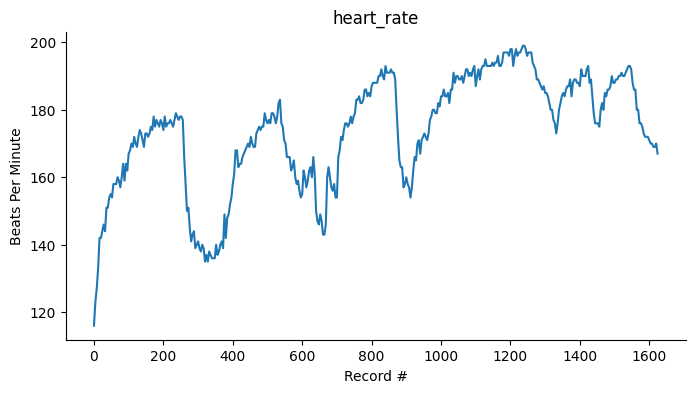

In [9]:
# @title heart_rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='heart_rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

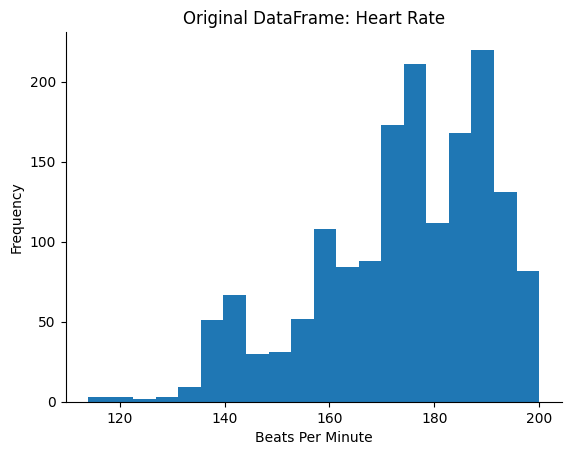

In [10]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

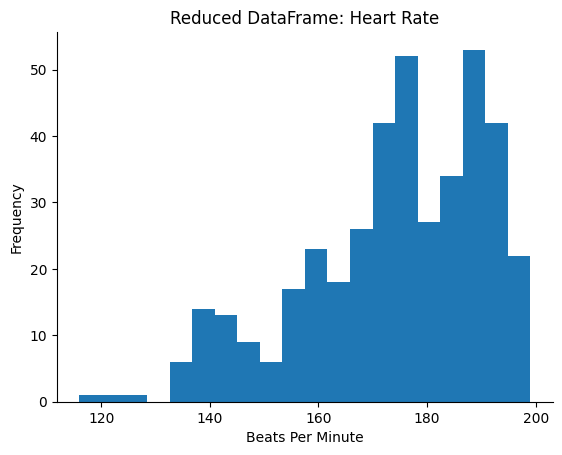

In [11]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

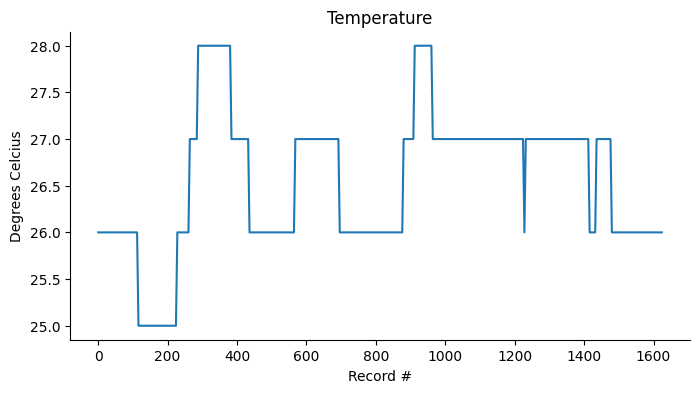

In [13]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

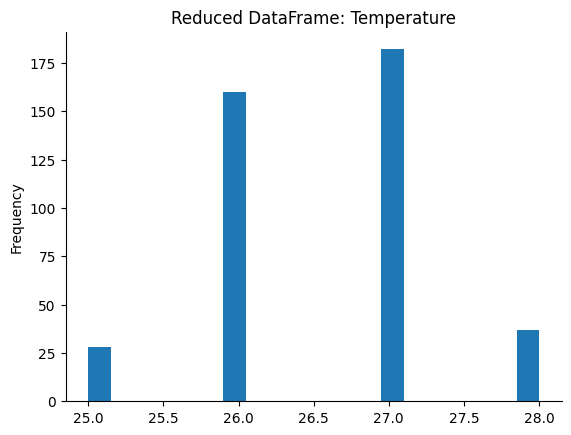

In [ ]:
# Visualize Temperature from the reduced DF
df_token_limitation['temperature'].plot(kind='hist', bins=20, title='Reduced DataFrame: Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_for_llm = df_token_limitation

from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Number of tokens in input prompt  9464


In [ ]:
instructPrompt = """
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

The dataset is provided below"""

request = instructPrompt + df_string

In [ ]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Summary of Treadmill Running Data:

1. The total distance covered during the running workouts is 16,502.59 meters.
2. The average heart rate during the workouts is 181 beats per minute.
3. The average cadence (steps per minute) during the workouts is 53 steps.
4. The average temperature during the workouts is 26 degrees Celsius.
5. The total duration of the running workouts is 9,427 seconds.

Recommendations to get better at running workouts:
1. Increase the distance gradually to improve endurance.
2. Focus on maintaining a consistent heart rate to improve cardiovascular fitness.
3. Work on increasing the cadence to improve running efficiency.
4. Pay attention to temperature, ensure a comfortable workout environment.
5. Aim to gradually increase the duration of the workouts to build stamina.

Table:

| Distance (km) | Time (hh:mm) | Average Pace (min/km) |
|--------------:|--------------|----------------------|
|         16.50 |     2:28:47  |            8:59       |
